# Agile Estimation: missed opportunity and missed deadlines #

Why the companies care when their development projects will be completed? Obviously, to get some benefit from the project sooner. It may be increase of sales or profit, or reduction of cost. We call is missed opportunity, and it has a cost in dollars. 

Calculating missed opportunity is easier and more straightforward and, what is more important, much less misleading, than calculating ROI. Just think about how many times the actual ROI from the software project was several orders of magnitude less than the projected? Using missed opportunity calculation also helps you prioritize the projects.

In this notebook we will try to estimate the probability distribution of the missed opportunity of a single project based on the number of story points the team can complete in one iteration. 
As discussed in [the previous notebook](agile_estimation_2.ipynb), we will use Log-Normal distribution to estimate project velocity.

In [56]:
import numpy as np
from scipy.stats import lognorm
data=np.array([14, 12,  7, 14, 13])
shape, loc, scale = lognorm.fit(data, floc=0)

Here we took the information about the past iteration of the team (14, 12,  7, 14, 13 story points respectively) and fitted it to the log-normal distribution. We are interested the question: How many iterations will a given number of story point(in this example 70) take. Again, we use the wonderful property of the log-normal distribution, that the inverse is also log-normal with the same parameter $\sigma$ and inversed parameter $-\mu$

In [57]:
num_points = 70
dist_iterations = lognorm(shape, loc, num_points/scale)
print(f'Mean: {dist_iterations.mean()}')
print(f'Median {dist_iterations.median()}')
print(f'Standard deviation {dist_iterations.std()}')

Mean: 6.219638285087961
Median 6.011776848254893
Standard deviation 1.6496339740439272


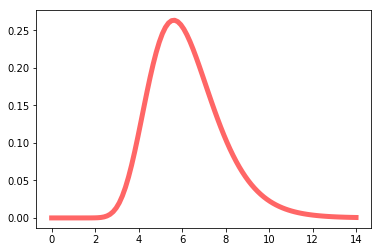

In [58]:
#We plot the distribution
%matplotlib inline
import matplotlib.pyplot as plt
def plot_dist(frozen, low=0, high=14):
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(low, high, 100)
    ax.plot(x, frozen.pdf(x), 'r-', lw=5, alpha=0.6, label='lognorm pdf')
plot_dist(dist_iterations);

So we see that we have a good chance to complete it within 7 iterations, but there is a chance it may take up to 12 iterations! Let's say the business is losing $10,000 per iteration as missed opportunity. Then the distribution of missed opportunity will be the following:

Mean: 62196.382850879614
Median 60117.768482548934
Standard deviation 16496.33974043927


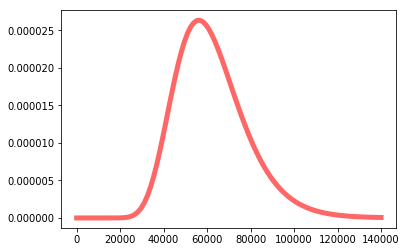

In [59]:
missed_opportunity_per_iteration = 10000
missed_opportunity = lognorm(shape, loc, num_points/scale*missed_opportunity_per_iteration)
print(f'Mean: {missed_opportunity.mean()}')
print(f'Median {missed_opportunity.median()}')
print(f'Standard deviation {missed_opportunity.std()}')
plot_dist(missed_opportunity, 0, 140000);

As we see, we have all incentives to complete the project sooner to move the curve to the left. Maybe we add more developers to increase velocity? We may also want to reduce scope to reduce the number of story points.

Finally, despite what some Agile theorists say, the business sets deadline for a reason. When a software project is done, the business has to do UAT, reach out to some of the customers and ask them to provide feedback, etc. The business would also like to plan this in advance, and since the closure activities have a fixed cost, if the project is not delivered on time, this will add to the project cost. We call it cost of delay.

If the missed opportunity cost is zero, then to avoid the cost of delay we plan the closure activities to as late as possible. But if it is non-zero, then there will be trade-off between two costs. So if $C$ is a closure cost, $C_o$ is the missed opportunity cost, $N$ is the actual number of iterations and $M$ is the number if iterations planned, then the total cost will be:

$$ T_c = M C_o + C P(N > M) $$

We need to minimize this cost over $M$

We can take a derivative with respect to M. Note, that $P(N > M)$ is what is called survival function, or $1 - CDF$, where CDF is the cumulative density function. The derivative of the survival function is negative probability density function. Thus the optimal value of M is defined by the equation:

$$ C_o - C p(M) = 0 $$

In this example we guess that the delay cost is $95,000

In [60]:
#We solve the equation numerically:
from scipy.optimize import *
delay_cost = 95000
def to_optimize(m):
    return missed_opportunity_per_iteration - delay_cost*dist_iterations.pdf(m)
roots = newton_krylov(to_optimize, 8.0)
float(roots)

7.994986056462073

This shows us, that even though the team will most likely complete project in six iterations, but due to the high cost of delay, it is better to schedule closure activities after eight iterations. 

In practice, the iterations are filled with so called "slack", i.e. low priority stories, that team does when all high priority stories are completed. If indeed the team is done in six iterations, it can work on the slack stories or address technical debt.